<a href="https://colab.research.google.com/github/rjromo/Transferencia-de-Estilo/blob/master/RNN_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RNN

En este notebook vamos a entrenar una redes neuronal recurrente de forma simple. Dado un set como datos iniciales seremos capaces de generar una predicción para el siguiente paso.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/time-series/assets/time_prediction.png?raw=1' width=40% />

> * Primero creamos nuestros datos
* Luego definimos una red usando Pytorch
* Finalmente entrenamos nuestra red y vemos como se desarrolla.

### Importamos recursos y creamos los datos

In [0]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

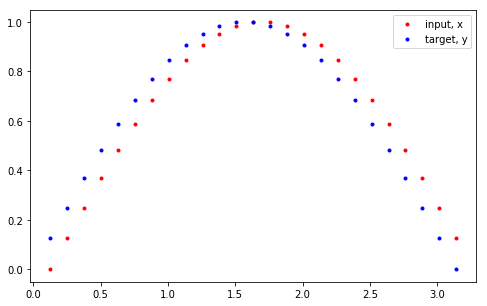

In [8]:
plt.figure(figsize=(8,5))

# cuantos pasos/puntos de datos están en un batch de datos
seq_length = 25

# generamos puntos espaciados
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # el tamaño es (seq_length+1, 1), se añada una dimensión input_size

x = data[:-1] # Todo menos el último dato
y = data[1:] # Todo menos el primer

# graficamos los datos
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

---
## Definiendo la RNN

Usaremos la librería  PyTorch `nn.RNN` para crear una capa RNN, luego por último añadiremos una capa completamente conectada para obtener el tamaño de salida que queremos. Una RNN toma los siguientes parametros:
* **input_size** - el tamaño de los valores de entrada
* **hidden_dim** - el número de features en la salida de la RNN y en los estados ocultos
* **n_layers** - el número de capas que hacen la RNN, tipicamente 1-3.
* **batch_first** - Si la entrada o salida de la RNN tendrá el tamaño del batch como primera dimensión. (batch_size, seq_length, hidden_dim)

Puedes ver más en [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) 

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define una RNN con los parámetros específicos
        # batch_first significa que la primera dimensión de la entrada y salida será el tamaño del batch
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # una capa completamente conectada "fully connected layer"
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # obtiene las salidas de la RNN
        r_out, hidden = self.rnn(x, hidden)
        # le da forma a la salida(batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # obtiene la salida final 
        output = self.fc(r_out)
        
        return output, hidden


### Revisar las dimensiones de entrada y salida

Para verificar que el modelo está trabajando según lo esperado.

In [24]:
# verifica que las dimensiones son las deseadas
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generar puntos 
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # darle un tamaño de batch de 1 como primera dimensión.
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 25, 1])
Output size:  torch.Size([25, 1])
Hidden state size:  torch.Size([2, 1, 10])


---
## Entrenando la RNN

Iniciaremos la RNN con hiperparámetros especificados. Luego la entrenaremos en una serie de pasos para ver como se desarrolla.

In [25]:
# hiperparámetros
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# iniciando la RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Perdida y Optimización

Este es un problema de regresión.

>*  Los puntos son coordenadas así que usaremos el error cuadrático medio
* Usamos optimizadores ADAM

In [0]:
# taza de aprendizaje 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Definiendo la función de entrenamiento.

Esta función toma una RNN, un número de pasos para entrenar y retorna una red entrenada.

#### Estados ocultos

Preste mucha atención en los estados ocultos:
* Al principio un estado oculto es generado
* Luego de este estado obtenemos uno nuevo que se usará recurrentemente.

In [0]:
# entrena la RNN
def train(rnn, n_steps, print_every):
    
    # inicializa el estado oculto
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # definiendo los datos de entrenamiento
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convirtiendo los datos en Tensores
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze da 1 como dimensión del tamaño del batch
        y_tensor = torch.Tensor(y)

        # salidas de la rnn
        prediction, hidden = rnn(x_tensor, hidden)

        
        hidden = hidden.data

        # calculando la pérdida
        loss = criterion(prediction, y_tensor)
        # reiniciando los gradientes
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()

        # visualización de pérdida
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.5326623916625977


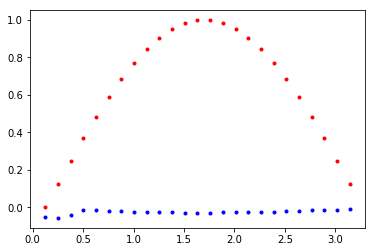

Loss:  0.05750281363725662


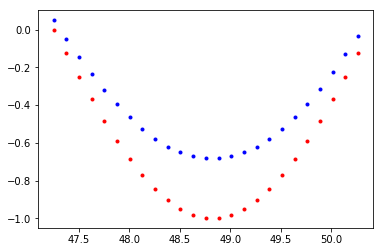

Loss:  0.0024190775584429502


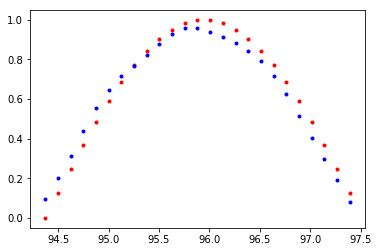

Loss:  0.010078910738229752


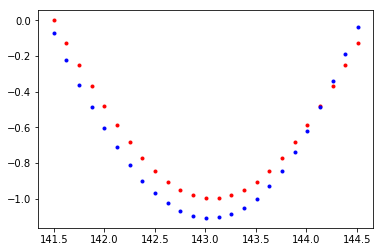

Loss:  0.005852646194398403


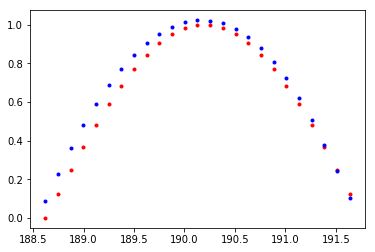

In [20]:
# entrena la red y muestra los resultados
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)